Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [2]:
train_data = pd.read_parquet('/content/train.parquet')

In [3]:
train_data

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


Вычисляем статистические параметры (среднее, медиана, стандартное отклонение, минимум, максимум и количество элементов)

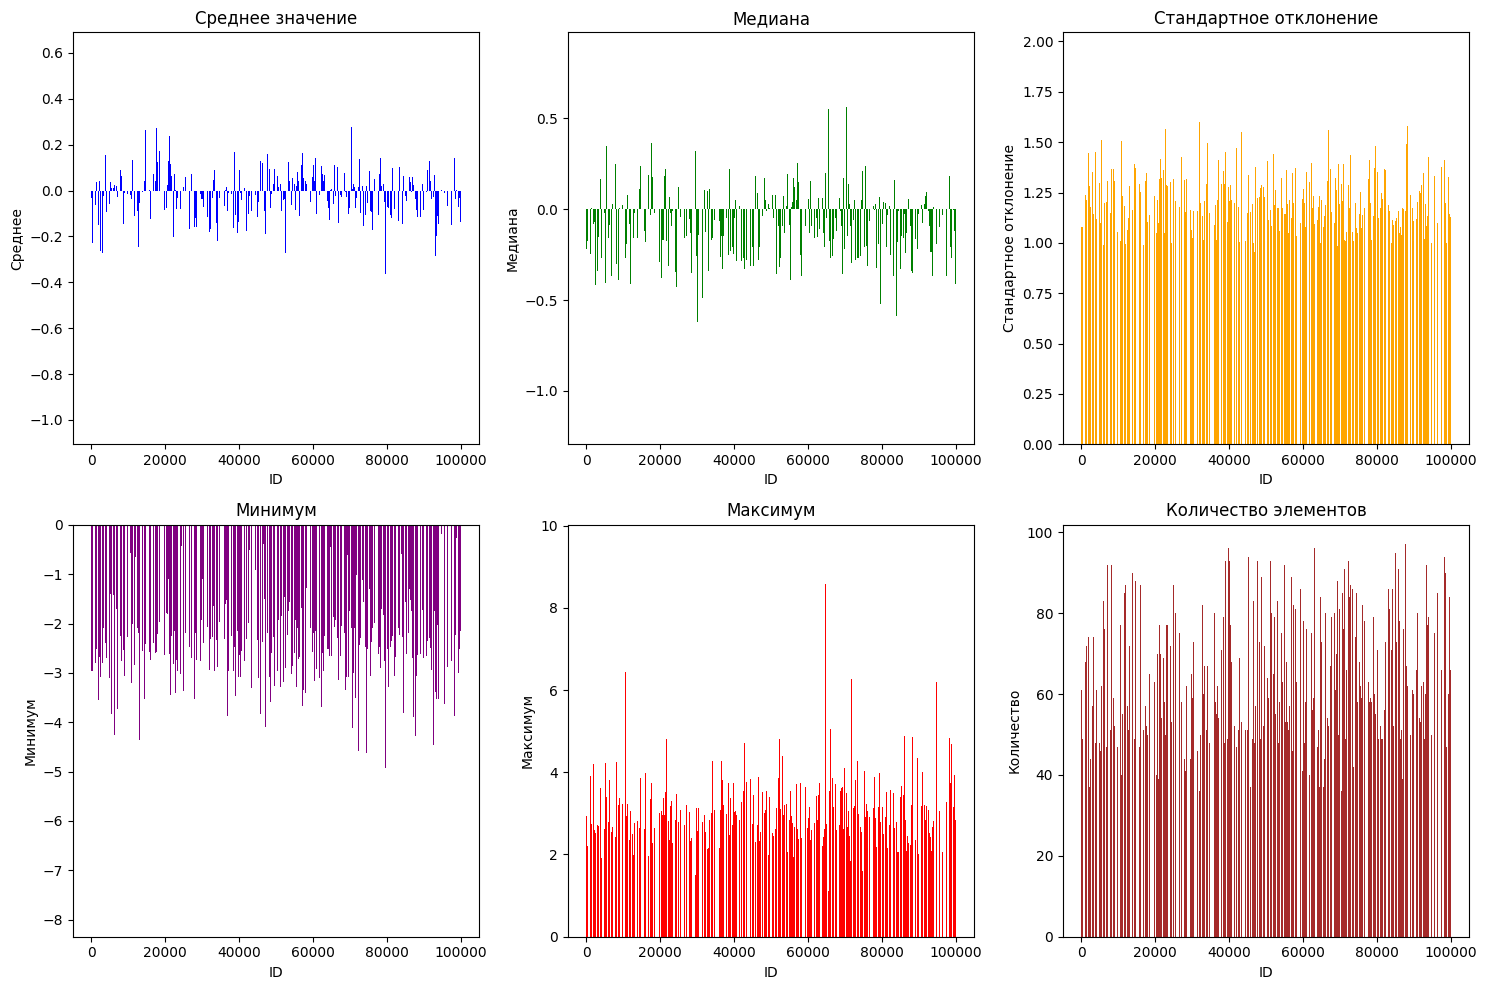

In [4]:
def describe_time_series_values(df):
    if 'values' not in df.columns:
        print("Колонка 'values' отсутствует в DataFrame.")
        return

    stats = []

    for index, row in df.iterrows():
        time_series = row['values']
        series_stats = {
            'id': row['id'],
            'mean': sum(time_series) / len(time_series),
            'median': pd.Series(time_series).median(),
            'std': pd.Series(time_series).std(),
            'min': min(time_series),
            'max': max(time_series),
            'count': len(time_series)
        }
        stats.append(series_stats)

    stats_df = pd.DataFrame(stats)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.bar(stats_df['id'], stats_df['mean'], color='blue')
    plt.title('Среднее значение')
    plt.xlabel('ID')
    plt.ylabel('Среднее')

    plt.subplot(2, 3, 2)
    plt.bar(stats_df['id'], stats_df['median'], color='green')
    plt.title('Медиана')
    plt.xlabel('ID')
    plt.ylabel('Медиана')

    plt.subplot(2, 3, 3)
    plt.bar(stats_df['id'], stats_df['std'], color='orange')
    plt.title('Стандартное отклонение')
    plt.xlabel('ID')
    plt.ylabel('Стандартное отклонение')

    plt.subplot(2, 3, 4)
    plt.bar(stats_df['id'], stats_df['min'], color='purple')
    plt.title('Минимум')
    plt.xlabel('ID')
    plt.ylabel('Минимум')

    plt.subplot(2, 3, 5)
    plt.bar(stats_df['id'], stats_df['max'], color='red')
    plt.title('Максимум')
    plt.xlabel('ID')
    plt.ylabel('Максимум')

    plt.subplot(2, 3, 6)
    plt.bar(stats_df['id'], stats_df['count'], color='brown')
    plt.title('Количество элементов')
    plt.xlabel('ID')
    plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

    return stats_df

stats_df = describe_time_series_values(train_data)

In [5]:
stats_df

,id,mean,median,std,min,max,count
0,19114,0.023710,-0.110000,1.348189,-4.840000,3.49,62
1,22769,-0.310777,-0.274409,1.573923,-3.534409,2.92,45
2,76935,-0.046042,-0.145000,1.076293,-1.950000,2.61,48
3,66297,-0.130000,-0.345000,1.170457,-2.220000,2.49,48
4,2191,-0.270536,-0.475000,1.282027,-2.500000,2.87,56
...,...,...,...,...,...,...,...
79995,71474,0.163818,0.160000,1.315984,-3.640000,2.56,55
79996,36908,-0.112555,-0.180000,1.228053,-2.590000,2.16,53
79997,63517,-0.201373,-0.140000,1.194318,-2.890000,2.27,51
79998,94731,-0.075397,0.240000,1.503232,-2.850000,3.11,63


Проверяем пропуски в данных

In [6]:
missing_values_train = train_data.isnull().sum()
missing_values_train

,0
id,0
dates,0
values,0
label,0


Смотрим на соотношение классов

In [7]:
def plot_class_distribution(y, title):
    class_counts = pd.Series(y).value_counts()
    plt.figure(figsize=(8, 5))
    class_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Классы')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

Выводим графики временных рядов из 2 разных классов

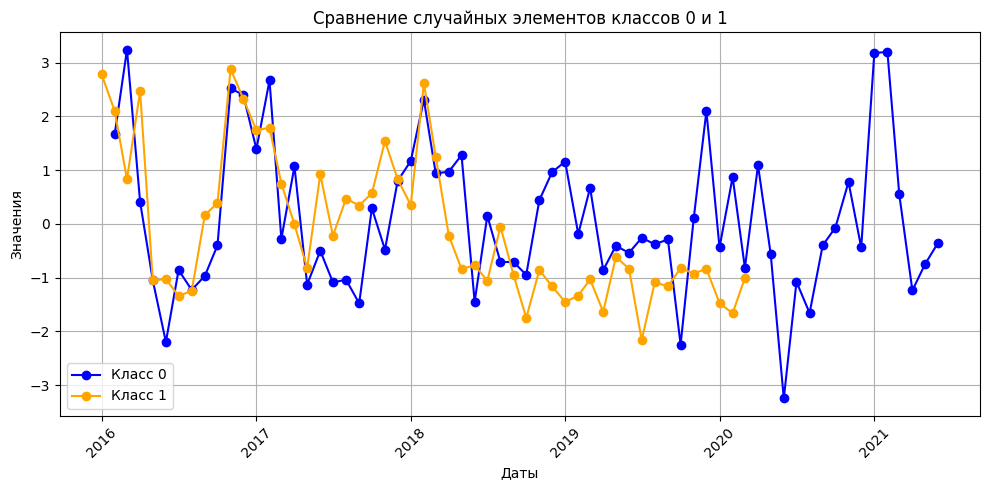

In [8]:
def plot_random_elements(df):
    class_0 = df[df['label'] == 0]
    class_1 = df[df['label'] == 1]

    random_element_0 = class_0.sample(n=1)
    random_element_1 = class_1.sample(n=1)

    dates_0 = random_element_0['dates'].values[0]
    values_0 = random_element_0['values'].values[0]

    dates_1 = random_element_1['dates'].values[0]
    values_1 = random_element_1['values'].values[0]

    plt.figure(figsize=(10, 5))
    plt.plot(dates_0, values_0, marker='o', label='Класс 0', color='blue')
    plt.plot(dates_1, values_1, marker='o', label='Класс 1', color='orange')
    plt.title('Сравнение случайных элементов классов 0 и 1')
    plt.xlabel('Даты')
    plt.ylabel('Значения')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_random_elements(train_data)

Выбираем 3 случайных временных ряда, применяем к ним три метода сглаживания (скользящее среднее, фильтр Савицкого-Голея и экспоненциальное сглаживание), и визуализирует результаты для каждого временного ряда.

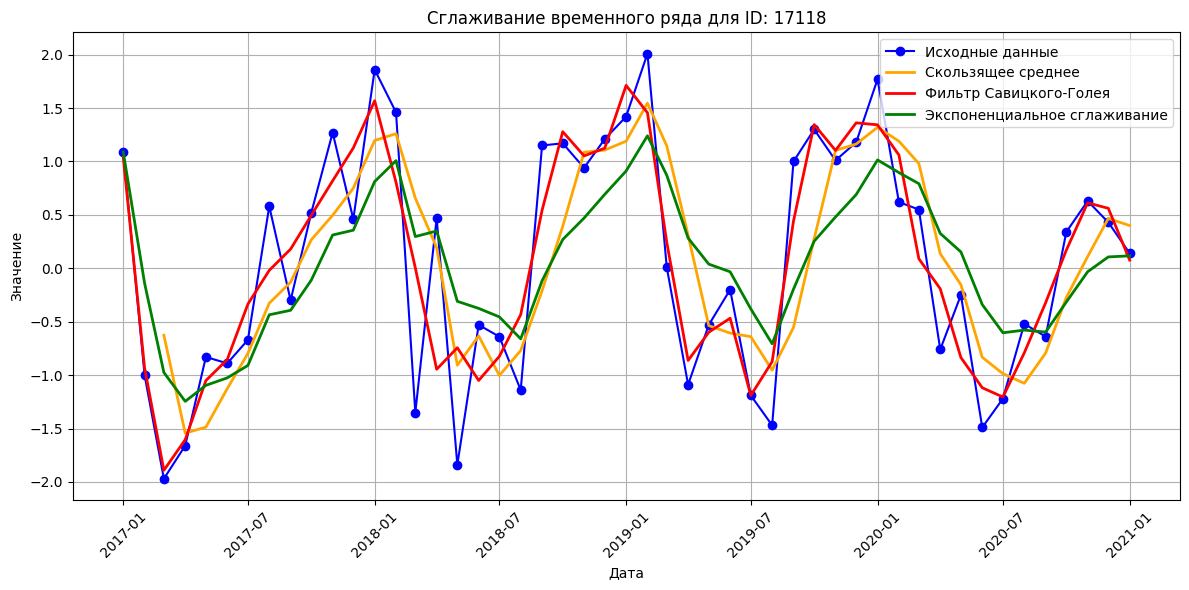

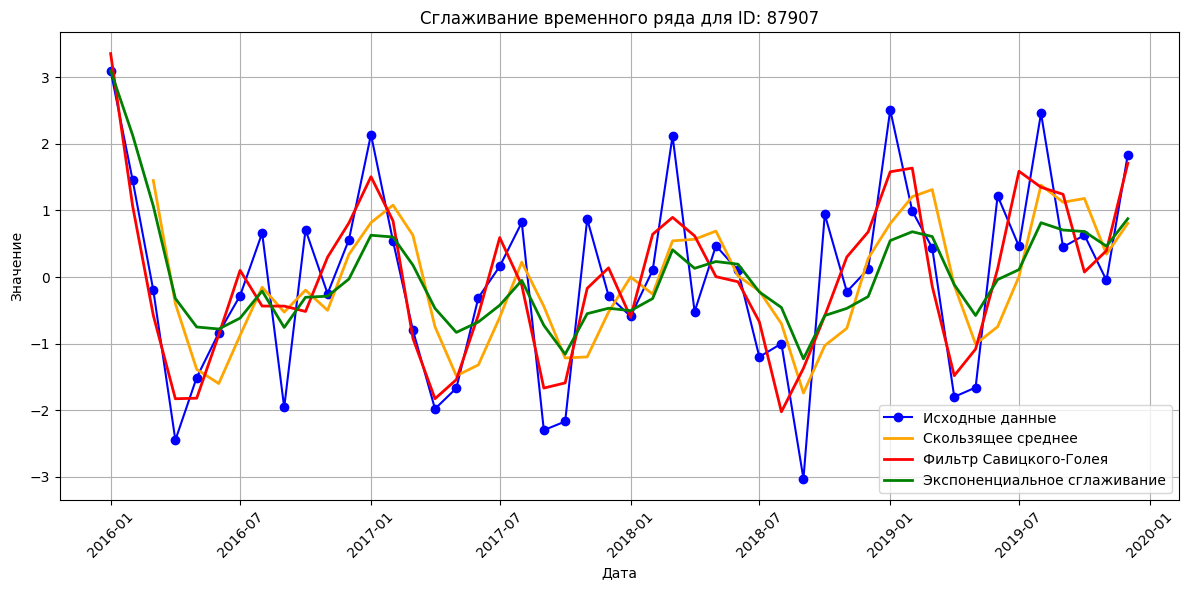

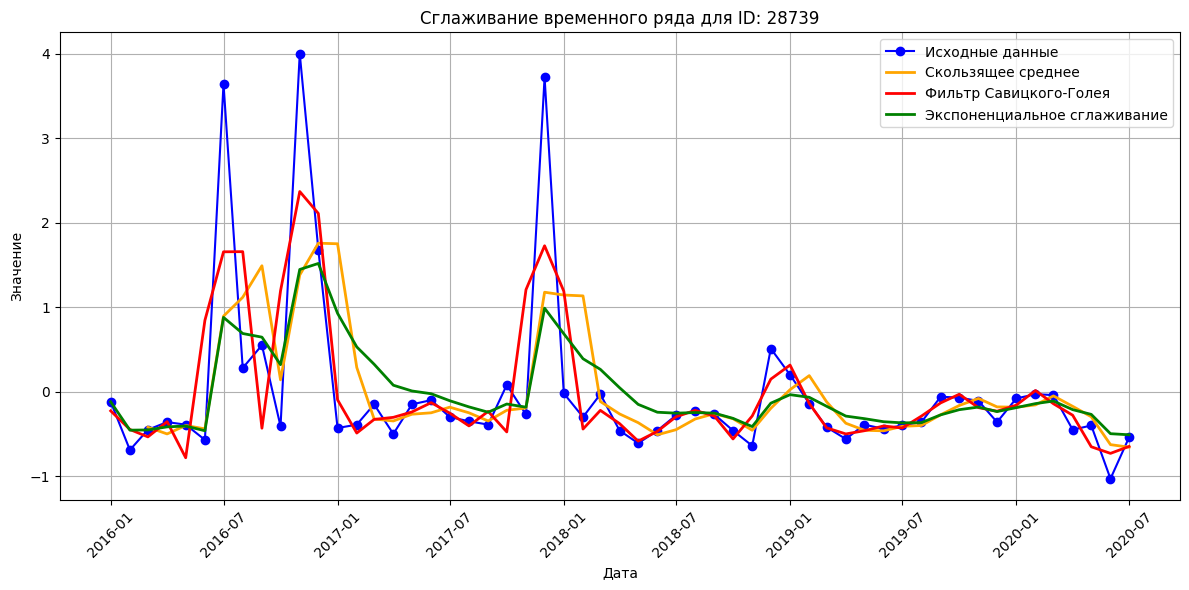

In [9]:
def smooth_time_series(df, window_size=3, alpha=0.3):
    if 'values' not in df.columns or 'dates' not in df.columns:
        print("Колонки 'values' и 'dates' должны присутствовать в DataFrame.")
        return

    sample_df = df.sample(n=3, random_state=1)

    for index, row in sample_df.iterrows():
        time_series = row['values']
        dates = row['dates']

        rolling_mean = pd.Series(time_series).rolling(window=window_size).mean()

        savgol_filtered = savgol_filter(time_series, window_length=min(5, len(time_series)), polyorder=2)

        exp_smoothing = pd.Series(time_series).ewm(alpha=alpha).mean()

        plt.figure(figsize=(12, 6))
        plt.plot(dates, time_series, label='Исходные данные', marker='o', color='blue')
        plt.plot(dates[window_size-1:], rolling_mean[window_size-1:], label='Скользящее среднее', color='orange', linewidth=2)
        plt.plot(dates, savgol_filtered, label='Фильтр Савицкого-Голея', color='red', linewidth=2)
        plt.plot(dates, exp_smoothing, label='Экспоненциальное сглаживание', color='green', linewidth=2)

        plt.title(f'Сглаживание временного ряда для ID: {row["id"]}')
        plt.xlabel('Дата')
        plt.ylabel('Значение')
        plt.legend()
        plt.grid()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

smooth_time_series(train_data)


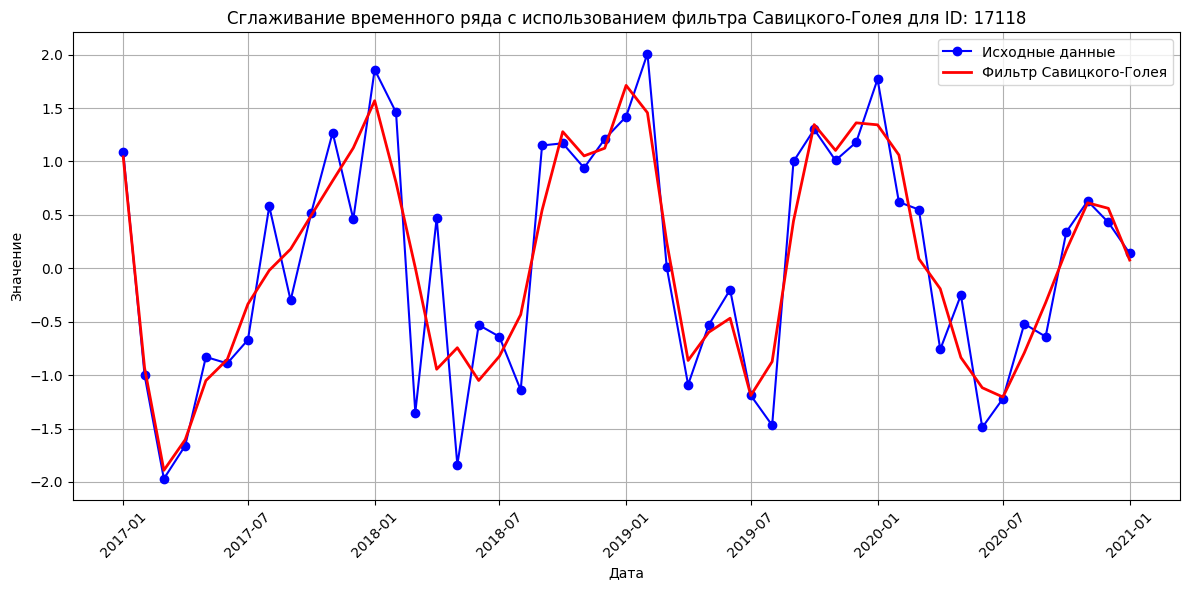

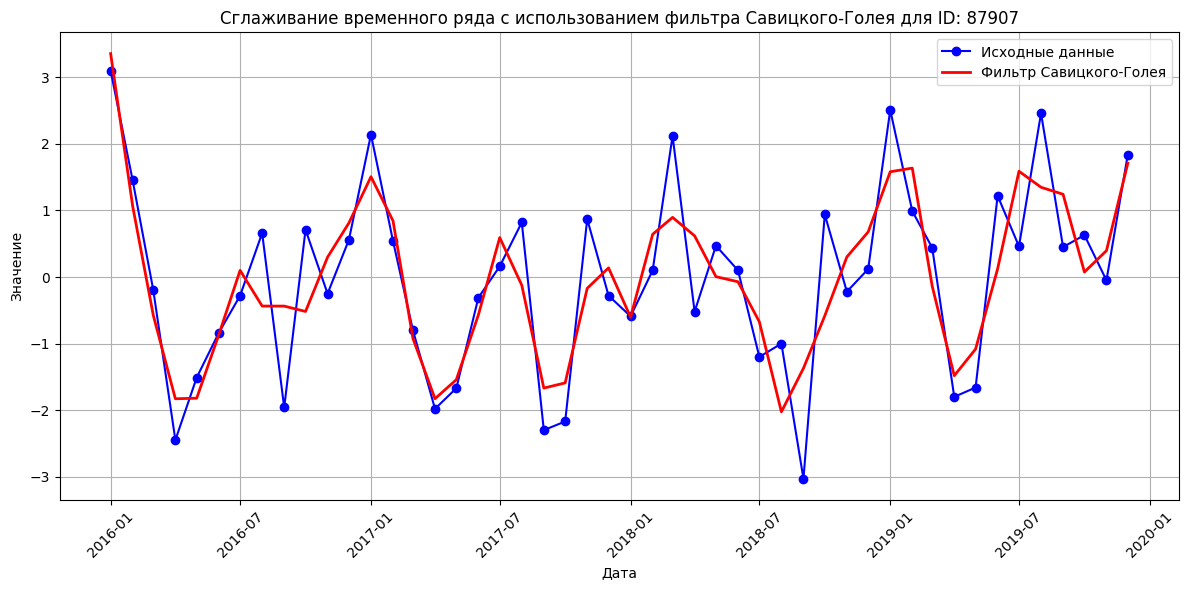

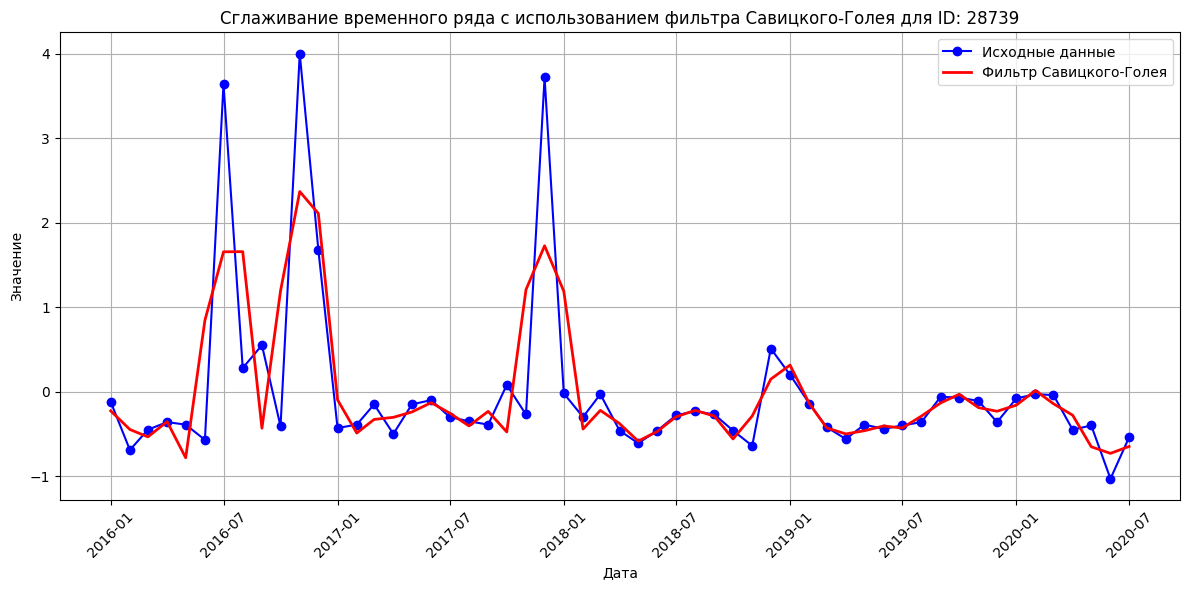

,id,dates,values,label
7126,17118,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...","[1.09, -1.0, -1.97, -1.66, -0.83, -0.89, -0.67...",0.0
46624,87907,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[3.1, 1.45, -0.2, -2.45, -1.51, -0.84, -0.28, ...",0.0
67020,28739,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.12, -0.69, -0.45, -0.36, -0.39, -0.57, 3.6...",0.0


In [10]:
def smooth_time_series_with_savgol(df, window_length=5, polyorder=2):
    if 'values' not in df.columns or 'dates' not in df.columns:
        print("Колонки 'values' и 'dates' должны присутствовать в DataFrame.")
        return

    sample_df = df.sample(n=3, random_state=1)

    for index, row in sample_df.iterrows():
        time_series = row['values']
        dates = row['dates']

        savgol_filtered = savgol_filter(time_series, window_length=min(window_length, len(time_series)), polyorder=polyorder)

        plt.figure(figsize=(12, 6))
        plt.plot(dates, time_series, label='Исходные данные', marker='o', color='blue')
        plt.plot(dates, savgol_filtered, label='Фильтр Савицкого-Голея', color='red', linewidth=2)

        plt.title(f'Сглаживание временного ряда с использованием фильтра Савицкого-Голея для ID: {row["id"]}')
        plt.xlabel('Дата')
        plt.ylabel('Значение')
        plt.legend()
        plt.grid()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return sample_df

smooth_time_series_with_savgol(train_data)


Нормализуем данные

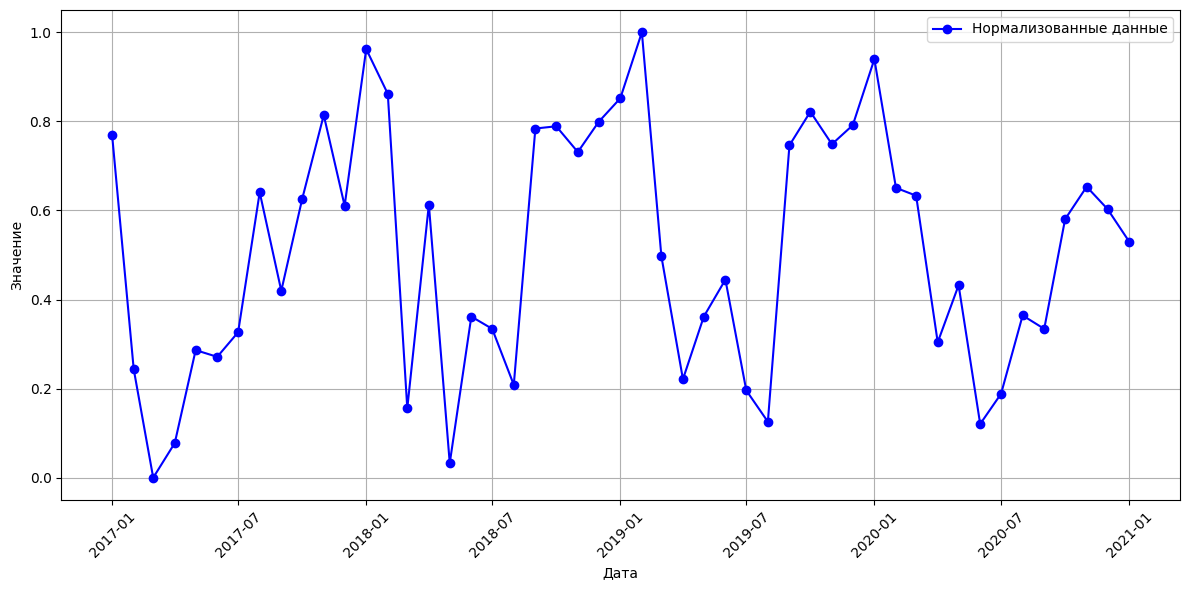

array([0.76884422, 0.24371859, 0.        , 0.07788945, 0.28643216,
       0.27135678, 0.32663317, 0.64070352, 0.41959799, 0.62562814,
       0.81407035, 0.61055276, 0.96231156, 0.86180905, 0.15577889,
       0.61306533, 0.03266332, 0.36180905, 0.33417085, 0.20854271,
       0.7839196 , 0.78894472, 0.73115578, 0.79899497, 0.85175879,
       1.        , 0.49748744, 0.22110553, 0.36180905, 0.44472362,
       0.1959799 , 0.12562814, 0.74623116, 0.82160804, 0.74874372,
       0.79145729, 0.93969849, 0.65075377, 0.63316583, 0.3040201 ,
       0.4321608 , 0.12060302, 0.18844221, 0.36432161, 0.33417085,
       0.58040201, 0.65326633, 0.60301508, 0.53015075])

In [11]:
def normalize_time_series(df, window_length=5, polyorder=2):
    if 'values' not in df.columns or 'dates' not in df.columns:
        print("Колонки 'values' и 'dates' должны присутствовать в DataFrame.")
        return

    sample_df = df.sample(n=3, random_state=1)
    scaler = MinMaxScaler()

    for index, row in sample_df.iterrows():
        time_series = np.array(row['values']).reshape(-1, 1)

        normalized_series = scaler.fit_transform(time_series).flatten()

        dates = row['dates']
        plt.figure(figsize=(12, 6))
        plt.plot(dates, normalized_series, label='Нормализованные данные', marker='o', color='blue')

        plt.xlabel('Дата')
        plt.ylabel('Значение')
        plt.legend()
        plt.grid()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        return normalized_series

normalize_time_series(train_data)


Подготавливаем данные для обучения модели LSTM, разделяем их на обучающую и валидационную выборки, строим и обучаем модель, оцениваем ее эффективность с помощью ROC AUC, classification_report, confusion_matrix и визуализируем результаты. Так же убираем дисбаланс классов с помощью ADASYN

In [12]:
from imblearn.over_sampling import ADASYN

def balance_data(X, y):
    ada = ADASYN(random_state=42)
    X_resampled, y_resampled = ada.fit_resample(X, y)
    return X_resampled, y_resampled

In [13]:
def prepare_data(train_data):
    X = train_data['values'].tolist()
    y = train_data['label'].values

    max_length = max(len(ts) for ts in X)
    X = pad_sequences(X, maxlen=max_length, padding='post')

    num_classes = len(np.unique(y))
    y = to_categorical(y, num_classes=num_classes)

    return X, y, num_classes

In [14]:
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
def reshape_data(X_train, X_val):
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    return X_train_lstm, X_val_lstm

In [16]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [17]:
def train_model(model, X_train_lstm, y_train, X_val_lstm, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train_lstm, y_train,
              epochs=15,
              batch_size=64,
              validation_data=(X_val_lstm, y_val),
              callbacks=[early_stopping])

In [18]:
def evaluate_model(model, X_val_lstm, y_val):
    y_val_proba = model.predict(X_val_lstm)
    y_val_true = np.argmax(y_val, axis=1)
    y_val_scores = y_val_proba[:, 1]

    fpr, tpr, thresholds = roc_curve(y_val_true, y_val_scores)
    roc_auc = auc(fpr, tpr)
    y_val_pred = np.argmax(y_val_proba, axis=1)

    return roc_auc, fpr, tpr, y_val_true, y_val_pred

In [19]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


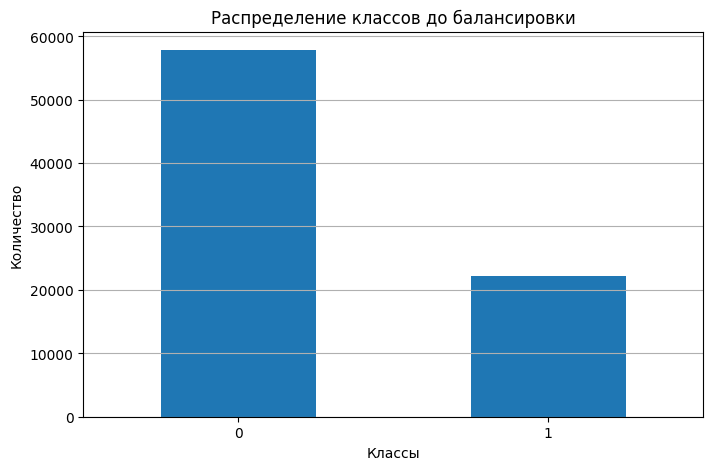

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:217: RuntimeWarning: invalid value encountered in cast
  X_new = X_new.astype(X.dtype)


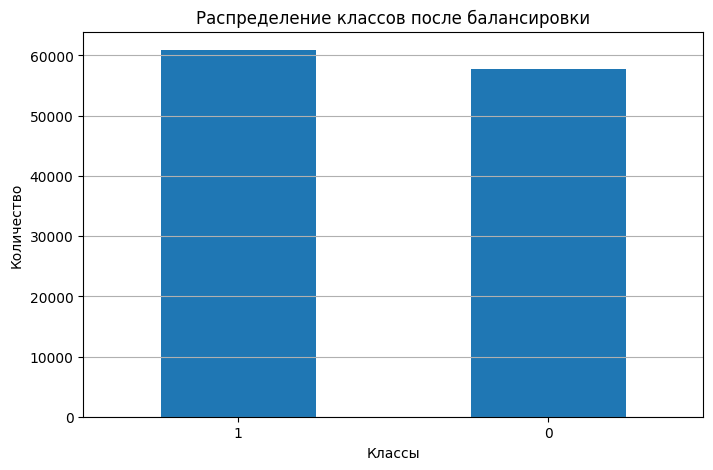

In [22]:
def plot_class_distribution(y, title):
    class_counts = pd.Series(y).value_counts()
    plt.figure(figsize=(8, 5))
    class_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Классы')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

X, y, num_classes = prepare_data(train_data)

y = np.argmax(y, axis=1)

plot_class_distribution(y, 'Распределение классов до балансировки')

X_balanced, y_balanced = balance_data(X, y)

y_balanced = np.squeeze(y_balanced)

plot_class_distribution(y_balanced, 'Распределение классов после балансировки')


In [23]:
X, y, num_classes = prepare_data(train_data)
X_train, X_val, y_train, y_val = split_data(X, y)

print(f"Форма y_train до преобразования: {y_train.shape}")
print(f"Форма y_val до преобразования: {y_val.shape}")

if len(y_train.shape) == 1:
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

print(f"Форма y_train после преобразования: {y_train.shape}")
print(f"Форма y_val после преобразования: {y_val.shape}")

X_train_lstm, X_val_lstm = reshape_data(X_train, X_val)

model = build_model((X_train_lstm.shape[1], 1), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_model(model, X_train_lstm, y_train, X_val_lstm, y_val)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


Форма y_train до преобразования: (64000, 2)
Форма y_val до преобразования: (16000, 2)
Форма y_train после преобразования: (64000, 2)
Форма y_val после преобразования: (16000, 2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7642 - loss: 0.5097 - val_accuracy: 0.8175 - val_loss: 0.4199
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8120 - loss: 0.4225 - val_accuracy: 0.8052 - val_loss: 0.4129
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8175 - loss: 0.4046 - val_accuracy: 0.8263 - val_loss: 0.3871
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8201 - loss: 0.4019 - val_accuracy: 0.8283 - val_loss: 0.3855
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8252 - loss: 0.3913 - val_accuracy: 0.8307 - val_loss: 0.3775
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8229 - loss: 0.3906 - val_accuracy: 0.8273 - val_loss: 0.3839
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8254 - loss: 0.3862 - val_accuracy: 0.8301 - val_loss: 0.3784
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8285 -

In [24]:
roc_auc, fpr, tpr, y_val_true, y_val_pred = evaluate_model(model, X_val_lstm, y_val)

print(f'Validation ROC AUC: {roc_auc:.4f}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Validation ROC AUC: 0.8820


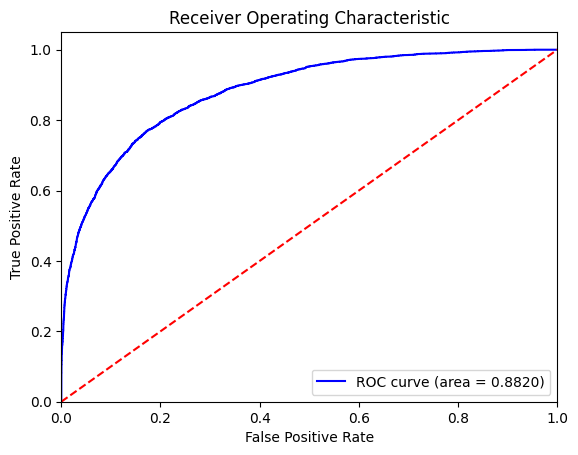

In [25]:
plot_roc_curve(fpr, tpr, roc_auc)

In [26]:
print_classification_report(y_val_true, y_val_pred)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89     11607
           1       0.76      0.60      0.67      4393

    accuracy                           0.84     16000
   macro avg       0.81      0.76      0.78     16000
weighted avg       0.83      0.84      0.83     16000



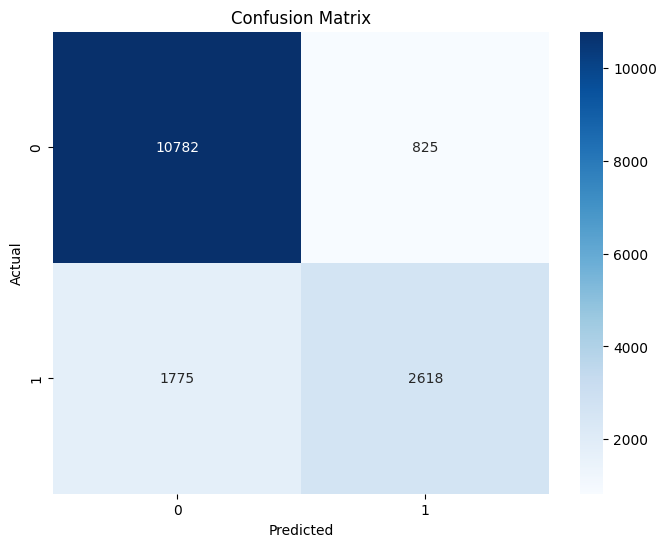

In [27]:
plot_confusion_matrix(y_val_true, y_val_pred)

In [29]:
def prepare_test_data(test_data):
    X_test = test_data['values'].tolist()
    max_length = max(len(ts) for ts in X_test)
    X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_test_lstm

def predict(test_data, model):
    X_test_lstm = prepare_test_data(test_data)
    y_test_proba = model.predict(X_test_lstm)
    return y_test_proba[:, 1]

def create_submission(test_data, probabilities):
    submission = pd.DataFrame({
        'id': test_data['id'],
        'score': probabilities
    })
    submission.to_csv('/content/submission_lstm.csv', index=False)

test_data = pd.read_parquet('/content/test.parquet')

probabilities = predict(test_data, model)

create_submission(test_data, probabilities)


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
